In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [49]:
df = pd.read_csv('quake.csv')

df.columns = ['latitude', 'longitude']

latitudes = df['latitude']
longitudes = df['longitude']
tabelas_juntas = pd.DataFrame({'latitude': latitudes, 'longitude': longitudes})


C:\Users\Luciano\AppData\Local\Temp\ipykernel_12200\4155088709.py:39: RuntimeWarning: divide by zero encountered in divide
  db_values[i] = np.sum((intra_cluster_distances[i] + intra_cluster_distances) / inter_cluster_distances[i, :])


   latitude  longitude  cluster
0     45.53     150.93        0
1     41.85     142.78        0
2     29.19     141.15        0
3    -21.66     169.81        0
4     23.09     120.58        0
Número ótimo de clusters: 4


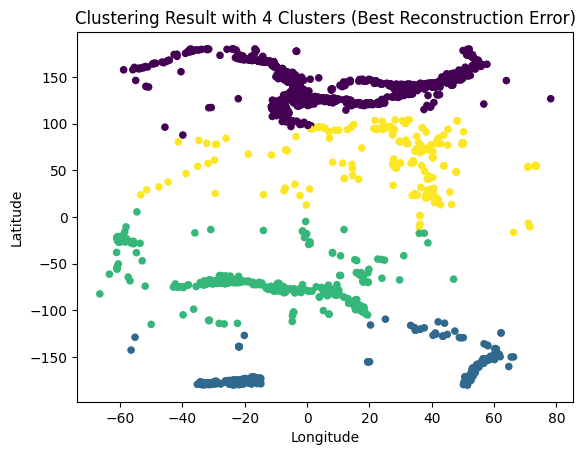

In [51]:
def kmeans_euclidean(data, k, max_iters=100):
    # Inicializar os centróides aleatoriamente
    centroids = data.sample(k, random_state=42)

    for _ in range(max_iters):
        # Calcular distâncias euclidianas entre pontos e centróides
        distances = np.linalg.norm(data.values[:, np.newaxis] - centroids.values, axis=2)

        # Atribuir rótulos com base nas menores distâncias
        labels = np.argmin(distances, axis=1)

        # Atualizar os centróides com a média dos pontos em cada cluster
        centroids = data.groupby(labels).mean()

    # Calcular o erro de reconstrução (soma dos quadrados das distâncias)
    reconstruction_error = np.sum((data.values - centroids.values[labels][:, np.newaxis]) ** 2)

    return labels, centroids, reconstruction_error

def davies_bouldin_index(data, labels, centroids):
    k = len(centroids)
    distances = np.linalg.norm(data.values[:, np.newaxis] - centroids.values, axis=2)

    # Calcular a dispersão intra-cluster (intra-cluster distance)
    intra_cluster_distances = np.zeros(k)
    for i in range(k):
        cluster_points = data[labels == i]
        intra_cluster_distances[i] = np.mean(np.linalg.norm(cluster_points.values - centroids.values[i], axis=1))

    # Calcular a dispersão média inter-cluster (average inter-cluster distance)
    inter_cluster_distances = np.zeros((k, k))
    for i in range(k):
        for j in range(i + 1, k):
            inter_cluster_distances[i, j] = np.linalg.norm(centroids.values[i] - centroids.values[j])

    # Calcular o índice Davies-Bouldin
    db_values = np.zeros(k)
    for i in range(k):
        db_values[i] = np.sum((intra_cluster_distances[i] + intra_cluster_distances) / inter_cluster_distances[i, :])

    return np.mean(np.max(db_values, axis=0))

# Número de execuções do K-means
num_execucoes = 20

# Inicializar com um erro de reconstrução grande para garantir que a primeira solução seja escolhida
melhor_erro_global = float('inf')
melhores_rotulos = None
melhores_centróides = None

# Testar diferentes números de grupos
for num_clusters in range(4, 21):
    db_values = []

    for _ in range(num_execucoes):
        # Executar o K-means
        labels, centroids, reconstruction_error = kmeans_euclidean(tabelas_juntas, k=num_clusters)

        # Calcular o índice Davies-Bouldin
        db = davies_bouldin_index(tabelas_juntas, labels, centroids)
        db_values.append(db)

        # Verificar se é a melhor solução até agora
        if reconstruction_error < melhor_erro_global:
            melhor_erro_global = reconstruction_error
            melhores_rotulos = labels
            melhores_centróides = centroids

    # Escolher o número ótimo de grupos com base no menor valor de Davies-Bouldin
    optimal_num_clusters = db_values.index(min(db_values)) + 4

# Adicionar os rótulos ao DataFrame original
df['cluster'] = melhores_rotulos

# Exibir o DataFrame com os rótulos de cluster
print(df.head())

# Exibir o número ótimo de clusters
print(f'Número ótimo de clusters: {optimal_num_clusters}')

# Plotar o resultado de agrupamento com o melhor modelo
plt.scatter(df['latitude'], df['longitude'], c=df['cluster'], cmap='viridis', s=20)
plt.title(f'Clustering Result with {optimal_num_clusters} Clusters (Best Reconstruction Error)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def kmeans_euclidean(data, k, max_iters=100):
    # Inicializar os centróides aleatoriamente
    centroids = data.sample(k, random_state=42).values

    for _ in range(max_iters):
        # Calcular distâncias euclidianas entre pontos e centróides
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)

        # Atribuir rótulos com base nas menores distâncias
        labels = np.argmin(distances, axis=1)

        # Atualizar os centróides com a média dos pontos em cada cluster
        centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])

    # Calcular o erro de reconstrução (soma dos quadrados das distâncias)
    reconstruction_error = np.sum((data - centroids[labels]) ** 2)

    return labels, centroids, reconstruction_error

def davies_bouldin_index(data, labels, centroids):
    k = len(centroids)
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)

    # Calcular a dispersão intra-cluster (intra-cluster distance)
    intra_cluster_distances = np.zeros(k)
    for i in range(k):
        cluster_points = data[labels == i]
        intra_cluster_distances[i] = np.mean(np.linalg.norm(cluster_points - centroids[i], axis=1))

    # Calcular a dispersão média inter-cluster (average inter-cluster distance)
    inter_cluster_distances = np.zeros((k, k))
    for i in range(k):
        for j in range(i + 1, k):
            inter_cluster_distances[i, j] = np.linalg.norm(centroids[i] - centroids[j])

    # Calcular o índice Davies-Bouldin
    db_values = np.zeros(k)
    for i in range(k):
        db_values[i] = np.sum((intra_cluster_distances[i] + intra_cluster_distances) / inter_cluster_distances[i, :])

    return np.mean(np.max(db_values, axis=0))

# Normalizar os dados
scaler = StandardScaler()
data_normalized = scaler.fit_transform(tabelas_juntas)

# Desnormalizar os dados antes de executar o K-means
data_desnormalized = scaler.inverse_transform(data_normalized)

# Número de execuções do K-means
num_execucoes = 20

# Inicializar com um erro de reconstrução grande para garantir que a primeira solução seja escolhida
melhor_erro_global = float('inf')
melhores_rotulos = None
melhores_centróides = None

# Testar diferentes números de grupos
for num_clusters in range(4, 21):
    db_values = []

    for _ in range(num_execucoes):
        # Executar o K-means
        labels, centroids, reconstruction_error = kmeans_euclidean(data_desnormalized, k=num_clusters)

        # Calcular o índice Davies-Bouldin
        db = davies_bouldin_index(data_desnormalized, labels, centroids)
        db_values.append(db)

        # Verificar se é a melhor solução até agora
        if reconstruction_error < melhor_erro_global:
            melhor_erro_global = reconstruction_error
            melhores_rotulos = labels
            melhores_centróides = centroids

    # Escolher o número ótimo de grupos com base no menor valor de Davies-Bouldin
    optimal_num_clusters = db_values.index(min(db_values)) + 4

# Adicionar os rótulos ao DataFrame original
df['cluster'] = melhores_rotulos

# Exibir o DataFrame com os rótulos de cluster
print(df.head())

# Exibir o número ótimo de clusters
print(f'Número ótimo de clusters: {optimal_num_clusters}')

# Plotar o resultado de agrupamento com o melhor modelo
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis', s=20)
plt.scatter(melhores_centróides[:, 1], melhores_centróides[:, 0], c='red', marker='X', s=200)
plt.title(f'Clustering Result with {optimal_num_clusters} Clusters (Best Reconstruction Error)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'sample'